In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras import layers
from tensorflow.compat.v1.keras.layers import Lambda, Input, Dense ,Input, Flatten, Multiply, Reshape, concatenate
from tensorflow.compat.v1.keras.losses import mse, binary_crossentropy
from tensorflow.compat.v1.keras.utils import plot_model
from  tensorflow.compat.v1.keras.initializers import glorot_uniform  # Or your initializer of choice
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras import backend as K
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Activation, Dropout,Conv1D, MaxPooling1D, Conv2DTranspose, BatchNormalization


In [3]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import seaborn as sn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os
import umap
import pandas as pd
from scipy import stats
import random

In [4]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [5]:
from  tensorflow.compat.v1.keras.initializers import glorot_uniform  # Or your initializer of choice

In [6]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [7]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

from factor_analyzer import FactorAnalyzer, Rotator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [8]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
# Define computing resource
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
tf.Session(config=config)

In [10]:
def sampling(m_v):

    z_mean, z_log_var = m_v #(mean and var)
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]

    epsilon = K.random_normal(shape=(batch, dim))
    sample = z_mean + K.exp(0.5 * z_log_var) * epsilon
    return sample

In [11]:
def save(fname, **kwargs):
      f = open(fname, "wt")
      for k, v in kwargs.items():
        print >>f, "%s=%s" % (k, repr(v))
      f.close()

def load(fname):
      ret = {}
      for line in open(fname, "rt"):
        k, v = line.strip().split("=", 1)
        ret[k] = eval(v)
      return ret



In [12]:
def masking(mask_data):
    inputs, outputs_unmasked =mask_data
    mask = tf.math.logical_not(tf.math.equal(inputs, 0))
    mask = tf.cast(mask, dtype=outputs_unmasked.dtype) #convert it to the same data type as the outputs_unmasked
    outputs_masked= outputs_unmasked*mask
    return outputs_masked
    

In [13]:
def filterTheDict(dictObj, callback):
    newDict = dict()
    for (key, value) in dictObj.items():
        if callback((key, value)):
            newDict[key] = value
    return newDict

def vae_loss(true, pred):

    reconstruction_loss = mse(K.flatten(true), K.flatten(pred)) * 79

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = 0.5 * reconstruction_loss + beta * 0.5 * kl_loss

    return vae_loss

In [14]:
os.getcwd()

'/Users/jianqiuzhang/Documents/Psychology/HEXACO'

In [15]:
os.chdir('/Users/jianqiuzhang/Documents/Psychology/HEXACO')

In [16]:
col_keys=pd.read_csv('keys_new12')
col_keys=list(col_keys.iloc[:,1])
print(col_keys)

['HSinc5', 'HMode5', 'HGree10', 'HSinc3', 'HGree4', 'AGent10', 'AGent8', 'HFair7', 'HSinc7', 'EAnxi4', 'EDepe1', 'EAnxi5', 'EAnxi2', 'EAnxi3', 'EAnxi1', 'EAnxi6', 'ESent10', 'EDepe8', 'CPrud3', 'CPrud2', 'COrga1', 'COrga3', 'CPerf2', 'COrga4', 'CDili3', 'CPrud1', 'CDili1', 'XSoci8', 'XSoci1', 'XExpr6', 'XSoci6', 'XSoci3', 'XExpr8', 'XSocB3', 'XSocB2', 'XExpr1', 'OCrea4', 'OCrea8', 'OCrea7', 'OUnco2', 'OInqu4', 'OCrea2', 'OAesA5', 'OCrea1', 'OInqu8', 'AForg4', 'HSinc10', 'APati1', 'AForg1', 'APati3', 'APati2', 'APati5', 'APati4', 'AGent4', 'EFear6', 'EFear8', 'EFear9', 'EFear10', 'EFear5', 'EFear3', 'OInqu2', 'OAesA9', 'OAesA4', 'OInqu9', 'OInqu5', 'HGree2', 'OInqu10', 'AGent2', 'CPrud4', 'CPerf10', 'CPrud5', 'CPrud9', 'OAesA6', 'OAesA10', 'OInqu1', 'OAesA7', 'OInqu3', 'OAesA1', 'ESent6']


In [17]:
# load data
data_read = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/HEXACO/data.csv')
col_name = list(data_read.columns)
data = data_read.iloc[:,col_name.index('HSinc1'):col_name.index('OUnco10')+1]
quality = data_read.iloc[:,col_name.index('V1'):col_name.index('V2')+1]
dropi=quality.query(('V1 < 7') or ('V2<7') ).index
dropindex=list(dropi)
#col_drop=col_name[col_name.index('F1'):col_name.index('N10')+1]
dropdata=data.drop(dropindex,axis=0)

#col_names = list(dropdata.columns)
#col_random=random.sample(col_names,len(col_names))
col_random=col_keys
#col_randomdf=pd.DataFrame(col_random)
#col_randomdf.to_csv('col_random')
#col_randomdf=pd.read_csv('col_random')
#col_random=list(col_randomdf.iloc[:,1])
dropdata=dropdata[col_random]
exp_data=dropdata.values

dropdata


/Users/jianqiuzhang/opt/miniconda3/envs/tf/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (243) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,HSinc5,HMode5,HGree10,HSinc3,HGree4,AGent10,AGent8,HFair7,HSinc7,EAnxi4,...,CPerf10,CPrud5,CPrud9,OAesA6,OAesA10,OInqu1,OAesA7,OInqu3,OAesA1,ESent6
0,2,5,2,5,2,6,5,1,6,2,...,2,2,5,1,2,7,6,5,5,7
1,5,4,6,5,2,5,5,5,5,3,...,3,5,5,1,4,5,5,7,7,3
2,5,6,3,6,4,4,3,2,2,3,...,6,2,6,1,2,5,2,5,6,6
3,6,5,6,3,3,4,3,5,5,6,...,5,6,6,2,4,6,4,6,6,6
4,2,6,4,5,5,3,3,7,1,5,...,6,5,4,1,5,5,2,3,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781,7,7,1,1,1,1,2,1,4,5,...,7,6,7,1,7,7,6,6,7,7
22782,1,4,3,2,3,3,3,3,3,3,...,5,4,4,4,3,5,3,6,4,7
22783,1,1,1,1,1,1,1,1,1,1,...,2,2,1,1,2,2,1,7,7,1
22784,1,7,2,5,6,2,3,1,1,7,...,3,1,4,1,1,7,5,7,7,3


In [18]:
code_book = pd.read_table('/Users/jianqiuzhang/Documents/Psychology/HEXACO/codebookItems.txt',delimiter=' I')
code_book.set_index('Code')
code_book.columns=list(['Code','Content'])
codes=list(code_book['Code'])
content=code_book['Content']
code_book.index=codes
code_book.drop(['Code'], axis=1)
code_book.loc['XExpr1']

/Users/jianqiuzhang/opt/miniconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Code             XExpr1
Content     talk a lot.
Name: XExpr1, dtype: object

In [19]:
#Normalize the data
zeroindex=(exp_data==0)
scaler = StandardScaler()
scaled_exp_data_df=dropdata.copy()
scaled_exp_data_df=pd.DataFrame(scaler.fit_transform(scaled_exp_data_df), columns=dropdata.columns)
scaled_exp_data=scaled_exp_data_df.values
scaled_exp_data[zeroindex]=0
scaled_X_train, scaled_X_test=train_test_split(scaled_exp_data, test_size=0.2, random_state=42)

In [20]:
## hyper params
input_nodes=79
latent_dim =12
hidden_nodes=160
hidden_nodes2=100


In [23]:
## VAE model
# build encoder
inputs = Input(shape=(input_nodes,), name='encoder_input')
block1 = Dense(hidden_nodes, kernel_initializer='he_normal', activation='relu')(inputs)
block1 = BatchNormalization(axis=-1)(block1)
flatten = Flatten()(block1)
z_mean = Dense(latent_dim, name='z_mean')(flatten)
z_log_var = Dense(latent_dim, name='z_log_var')(flatten)



In [24]:
# use reparameterization trick
x = [z_mean, z_log_var]
z = Lambda(sampling, name='z_sample')(x)

# instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

In [25]:
# build decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
de_block1 = Dense(hidden_nodes, activation='relu')(latent_inputs)
de_block1 = BatchNormalization()(de_block1)
outputs_unmasked = Dense(input_nodes, activation='linear')(de_block1)


In [26]:
embedding = layers.Embedding(input_dim=240, output_dim=240, mask_zero=True)
masked_output = embedding(inputs)
#print(masked_output._keras_mask)
masking_layer = layers.Masking()
outputs = masking_layer(outputs_unmasked)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
# instantiate decoder
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [28]:
# show summary
plot_model(vae, to_file='beta-vae.png', show_shapes=True)
encoder.summary()
decoder.summary()
vae.summary()

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 79)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 160)          12800       encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160)          640         dense_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 160)          0           batch_normalization_1[0][0]      
______

In [29]:
## hyper params
batch_size = 64
epochs =100
lr = 0.0005
decay = 1e-6
beta = 1


In [30]:
# Compiling
adam = Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=decay, amsgrad=True)
vae.compile(optimizer= adam, loss = vae_loss, metrics=['acc'])

In [31]:
initial_weights = vae.get_weights()

backend_name = K.backend()
if backend_name == 'tensorflow': 
    k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
elif backend_name == 'theano': 
    k_eval = lambda placeholder: placeholder.eval()
else: 
    raise ValueError("Unsupported backend")

new_weights = [k_eval(glorot_uniform()(w.shape)) for w in initial_weights]

vae.set_weights(new_weights)

In [32]:
hist = vae.fit(scaled_X_train, scaled_X_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, shuffle=True, verbose=2)


Train on 10516 samples, validate on 4507 samples
Epoch 1/100
10516/10516 - 5s - loss: 39.6693 - acc: 0.0146 - val_loss: nan - val_acc: 0.0149
Epoch 2/100
10516/10516 - 2s - loss: 35.0091 - acc: 0.0488 - val_loss: 31.8073 - val_acc: 0.0659
Epoch 3/100
10516/10516 - 2s - loss: 30.8205 - acc: 0.0687 - val_loss: 29.8306 - val_acc: 0.0746
Epoch 4/100
10516/10516 - 2s - loss: 29.5244 - acc: 0.0845 - val_loss: 28.6847 - val_acc: 0.0996
Epoch 5/100
10516/10516 - 2s - loss: 28.6010 - acc: 0.1056 - val_loss: 28.1220 - val_acc: 0.1109
Epoch 6/100
10516/10516 - 2s - loss: 28.2425 - acc: 0.1165 - val_loss: 27.8585 - val_acc: 0.1207
Epoch 7/100
10516/10516 - 2s - loss: 28.0220 - acc: 0.1269 - val_loss: 27.7041 - val_acc: 0.1393
Epoch 8/100
10516/10516 - 2s - loss: 27.8942 - acc: 0.1317 - val_loss: 27.6359 - val_acc: 0.1294
Epoch 9/100
10516/10516 - 2s - loss: 27.7664 - acc: 0.1374 - val_loss: 27.4926 - val_acc: 0.1458
Epoch 10/100
10516/10516 - 2s - loss: 27.6471 - acc: 0.1463 - val_loss: 27.4207 - 

Epoch 85/100
10516/10516 - 3s - loss: 26.6193 - acc: 0.2028 - val_loss: 26.5602 - val_acc: 0.2024
Epoch 86/100
10516/10516 - 2s - loss: 26.6295 - acc: 0.2107 - val_loss: 26.5633 - val_acc: 0.2097
Epoch 87/100
10516/10516 - 2s - loss: 26.5939 - acc: 0.2013 - val_loss: 26.5173 - val_acc: 0.2015
Epoch 88/100
10516/10516 - 2s - loss: 26.6031 - acc: 0.1997 - val_loss: 26.5302 - val_acc: 0.2092
Epoch 89/100
10516/10516 - 2s - loss: 26.5758 - acc: 0.2052 - val_loss: 26.5812 - val_acc: 0.1930
Epoch 90/100
10516/10516 - 2s - loss: 26.5837 - acc: 0.2032 - val_loss: 26.5706 - val_acc: 0.2028
Epoch 91/100
10516/10516 - 2s - loss: 26.6035 - acc: 0.2077 - val_loss: 26.5522 - val_acc: 0.2015
Epoch 92/100
10516/10516 - 2s - loss: 26.5847 - acc: 0.2082 - val_loss: 26.5420 - val_acc: 0.2039
Epoch 93/100
10516/10516 - 3s - loss: 26.6024 - acc: 0.2033 - val_loss: 26.5282 - val_acc: 0.2043
Epoch 94/100
10516/10516 - 2s - loss: 26.5764 - acc: 0.2066 - val_loss: 26.5566 - val_acc: 0.2006
Epoch 95/100
10516/1

MSE is: 0.5371450304919478


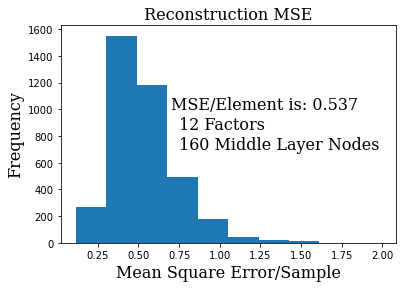

In [37]:
# reconstruction performance
latent_pred = encoder.predict(scaled_X_test)[2]
recon= decoder.predict(latent_pred)
#recon = vae.predict(scaled_X_test)
recon_loss_1 = ((scaled_X_test - recon) ** 2).mean(axis=1)
plt.hist(recon_loss_1)
plt.title(' Reconstruction MSE ', fontdict=font)
recon_loss = ((scaled_X_test - recon) ** 2).mean(axis=None)
format_float = "{:.3f}".format(recon_loss)
print_text='MSE/Element is: '+str(format_float)
xpos=0.75
ytop=1000
ystep=150
plt.text(xpos-0.05, ytop, print_text, fontdict=font)
plt.text(xpos, ytop-ystep, '12 Factors', fontdict=font)
plt.text(xpos, ytop-ystep*2, node + ' Middle Layer Nodes', fontdict=font)
plt.xlabel('Mean Square Error/Sample', fontdict=font)
plt.ylabel('Frequency', fontdict=font)
print('MSE is:', recon_loss)

plt.show()
#plt.savefig('Big5MSEHist1ReluGreat1.png')

In [38]:
loss,_  = vae.evaluate(scaled_X_test, scaled_X_test, batch_size=64, verbose=0)

print('Test loss vae:', loss)


Test loss vae: 26.645489248858727


In [39]:
decoder.save('Big12Hexaco79Layer1DecoderReluCopy1.h5')
encoder.save('Big12Hexaco79Layer1EncoderReluCopy1.h5')
#vae.save('HexacovaeGood2.h5')

In [40]:
filename='Big12Hexaco79Layer1DecoderReluCopy1'

In [ ]:
#decoder=keras.models.load_model('/Users/jianqiuzhang/Documents/Psychology/HEXACO/Big12Hexaco79Layer1DecoderReluCopy3.h5')
#encoder=keras.models.load_model('/Users/jianqiuzhang/Documents/Psychology/HEXACO/Big12Hexaco79Layer1DecoderReluCopy3.h5')
#scaled_X_train, scaled_X_test=train_test_split(scaled_exp_data, test_size=0.2, random_state=42)


In [41]:
latent_pred_sample = encoder.predict(scaled_exp_data)[0]
out=decoder.predict(latent_pred_sample)
indata=pd.DataFrame(data=scaled_exp_data, columns=col_random)
inout=pd.DataFrame(data=out, columns=col_random)
factors=[]
for i in range(latent_dim):
    factors.append('F'+str(i))
factor_names=list(factors)    
#factor_names=list(['F0','F1','F2','F3','F4','F5','F6','F7','F8'])
for i in range(latent_dim):
    inout.insert(i,factor_names[i],latent_pred_sample[:,i],True)

inout

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,CPerf10,CPrud5,CPrud9,OAesA6,OAesA10,OInqu1,OAesA7,OInqu3,OAesA1,ESent6
0,-0.547340,0.321155,-0.521609,-0.667134,1.194584,0.616334,0.952861,0.101727,-0.934818,-1.044904,...,-0.474098,-0.721388,-0.285091,0.083817,0.646170,0.278937,0.838833,0.175011,-0.513915,0.754597
1,1.179351,-0.186618,-0.383540,0.521422,0.035439,-0.219021,-0.590066,-0.723844,-0.279441,-0.971966,...,-0.116680,-0.243137,-0.081703,-0.381048,-0.275011,0.474022,-0.250842,0.422628,0.445666,0.332045
2,0.822423,0.548955,0.388522,0.699507,-0.212613,0.096057,1.051729,0.317545,-0.561819,0.342269,...,0.396497,0.136460,0.269999,-0.344447,0.008495,0.252842,-0.041309,0.306829,0.291497,0.371646
3,0.316304,-0.021830,0.921788,-0.440276,-0.773590,0.108143,0.597496,0.309328,-0.112767,0.348973,...,0.329783,0.600764,0.424140,-0.102456,0.527801,-0.461691,0.799929,-0.687216,-0.215589,0.205739
4,-0.079486,0.536734,0.968131,0.749729,-0.760875,1.116711,0.156330,-0.349707,0.796320,1.484557,...,0.511115,0.728974,0.152728,0.002362,0.042695,-1.186207,0.415763,-1.451052,-0.276623,-0.032219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18774,1.010972,-0.970312,-0.305139,0.319521,0.721568,-1.896508,2.487564,1.883651,-1.879294,0.393940,...,0.903710,0.234680,0.801625,-0.212077,0.811664,0.724000,0.498172,0.862597,0.248693,0.861389
18775,-0.278320,0.159152,0.674553,0.703293,0.929658,-0.912538,-0.849352,0.705957,-0.800981,1.010020,...,-0.031123,-0.192895,-0.792991,1.365654,0.582033,0.206594,0.773841,0.064626,-1.269274,0.423509
18776,-1.290143,0.638520,0.265700,0.290224,1.114895,0.539747,-0.968946,-1.738070,-0.798694,1.088510,...,-0.058012,-1.163916,-1.986077,-0.588955,-1.235591,0.133469,-1.245607,0.229634,0.780697,-1.091630
18777,1.070572,-0.726081,-0.387005,0.655887,1.493963,0.013522,0.070169,0.472378,2.685177,-1.384717,...,-0.946140,-0.973980,-0.223580,-0.356280,-0.885449,0.974000,-0.878716,1.040465,0.600961,-0.739647


In [42]:
latent_dim=len(latent_pred_sample[0])
max_items=240
ffCorr=inout.corr()
facLoad=ffCorr.iloc[latent_dim:max_items+latent_dim,0:latent_dim]
idx=list(facLoad.index)
col=list(facLoad.columns)
factor_loadings=facLoad
#Get the rotated Factors
rotator = Rotator()
facLoadRotate=rotator.fit_transform(facLoad)
factor_loadings=pd.DataFrame(facLoadRotate,index=idx,columns=col)
factor_loadings

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11
HSinc5,0.954978,-0.143635,-0.051908,-0.068579,-0.037559,-0.139564,0.084469,0.058701,-0.125888,-0.116720,-0.030707,-0.055340
HMode5,0.911014,0.079431,-0.135378,0.048176,0.162115,0.117838,-0.013502,0.124366,0.100644,-0.199508,0.114846,0.089402
HGree10,0.937507,0.021181,0.000690,0.119691,0.135555,0.093482,0.068773,0.086179,-0.057912,-0.224261,0.006521,0.003717
HSinc3,0.985499,-0.050362,-0.112319,-0.143940,0.063966,-0.038243,-0.012936,0.011479,-0.009322,0.069953,-0.004338,-0.035188
HGree4,0.903605,0.140169,-0.162327,-0.000959,0.227880,0.071069,0.003905,0.109971,0.105493,-0.202227,0.069151,0.055588
...,...,...,...,...,...,...,...,...,...,...,...,...
OInqu1,0.025350,-0.184236,-0.156530,0.171200,0.332115,0.068930,-0.642672,0.254944,-0.069006,0.141452,0.143820,0.416692
OAesA7,0.296484,-0.181343,0.059264,0.144525,0.058306,-0.011040,0.285917,0.775380,-0.154384,-0.051051,-0.348238,-0.046850
OInqu3,0.038329,-0.162564,-0.166421,0.175774,0.328713,0.089993,-0.796876,0.118050,-0.036430,0.138799,0.263484,0.074542
OAesA1,-0.088624,-0.150037,-0.047931,-0.270942,-0.038022,-0.034233,-0.145220,-0.735743,0.051226,0.061887,0.345142,-0.003732


          0         1         2         3         4         5         6   \
0   1.000000 -0.046858 -0.042716 -0.043525  0.055470 -0.028689  0.019551   
1  -0.046858  1.000000  0.072833  0.018080  0.023681  0.024664 -0.039268   
2  -0.042716  0.072833  1.000000 -0.055906 -0.024111  0.017312  0.032572   
3  -0.043525  0.018080 -0.055906  1.000000  0.022771  0.035447 -0.049660   
4   0.055470  0.023681 -0.024111  0.022771  1.000000  0.011767 -0.049581   
5  -0.028689  0.024664  0.017312  0.035447  0.011767  1.000000  0.011722   
6   0.019551 -0.039268  0.032572 -0.049660 -0.049581  0.011722  1.000000   
7   0.047097 -0.004037  0.024481  0.056290  0.029111 -0.015073  0.017266   
8  -0.026079 -0.007951 -0.042596 -0.008002 -0.031079 -0.023722 -0.033388   
9  -0.045010 -0.095634 -0.046343  0.062245  0.074916 -0.005808  0.003707   
10  0.011080  0.004249 -0.033206 -0.007715  0.018165  0.010108 -0.033932   
11 -0.009883 -0.003171 -0.000143  0.009286  0.018191  0.009436  0.012527   

          7

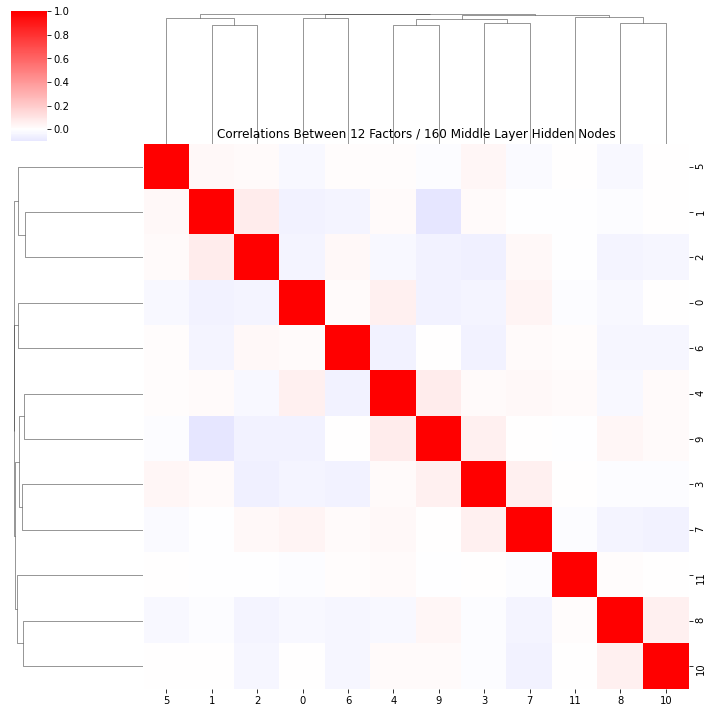

In [48]:
#Get the rotated latent factors
latent_pred = encoder.predict(scaled_exp_data)[0] @ rotator.rotation_ 
#print(latent_pred)
#pearson_coef, p_value = stats.pearsonr(latent_pred[:,0], latent_pred[:,2])
#print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)
corr_df = pd.DataFrame(data=latent_pred)
corr = corr_df.corr()
cluster_plot=sn.clustermap(corr, cmap='bwr', center=0)
#cluster_plot.fig.suptitle('')
node=str(hidden_nodes)
cluster_plot.ax_heatmap.set_title('Correlations Between 12 Factors / '+ node+' Middle Layer Hidden Nodes')
#cluster_plot.title('Basic 3 Factors Correlation Dendrogram)            
#cluster_plot.savefig("Big5ClusterReluGreat1.png")
print(corr)
corr=corr.round(2)
corr.to_csv(CurrentFilename+'corrOfRotatedFactors2.csv', index=True, header=True)

In [44]:
factor_columns=list(factor_loadings.columns)
factor_loadings_abs=factor_loadings.abs()

sorted_factor_loadings=factor_loadings

print(sorted_factor_loadings)

               F0        F1        F2        F3        F4        F5        F6  \
HSinc5   0.954978 -0.143635 -0.051908 -0.068579 -0.037559 -0.139564  0.084469   
HMode5   0.911014  0.079431 -0.135378  0.048176  0.162115  0.117838 -0.013502   
HGree10  0.937507  0.021181  0.000690  0.119691  0.135555  0.093482  0.068773   
HSinc3   0.985499 -0.050362 -0.112319 -0.143940  0.063966 -0.038243 -0.012936   
HGree4   0.903605  0.140169 -0.162327 -0.000959  0.227880  0.071069  0.003905   
...           ...       ...       ...       ...       ...       ...       ...   
OInqu1   0.025350 -0.184236 -0.156530  0.171200  0.332115  0.068930 -0.642672   
OAesA7   0.296484 -0.181343  0.059264  0.144525  0.058306 -0.011040  0.285917   
OInqu3   0.038329 -0.162564 -0.166421  0.175774  0.328713  0.089993 -0.796876   
OAesA1  -0.088624 -0.150037 -0.047931 -0.270942 -0.038022 -0.034233 -0.145220   
ESent6   0.329033 -0.248861 -0.145402  0.506779  0.148589  0.089599 -0.064735   

               F7        F8

In [45]:
sortAllF=pd.DataFrame(columns=factor_columns)
for i in range(latent_dim):
   current_factor=sorted_factor_loadings.iloc[0:240,i]
   #print(current_factor)
   current_factor_abs=current_factor.abs()
   current_factor_abs.sort_values(axis = 0, ascending = False, inplace = True, na_position ='last')      
   idx=current_factor_abs[current_factor_abs>0.1].index
   sorted_currentFactor=current_factor.loc[idx]
   #print(sorted_currentFactor)

   current_sortAllF=sorted_factor_loadings.loc[idx] 
   #print(current_sortAllF) 
   if(len(sorted_currentFactor)>0):
      first=sorted_currentFactor.iloc[0]
      print(first) 
      if(sorted_currentFactor.iloc[0]<0):
         current_sortAllF *=(-1)
      length_cf=sorted_currentFactor.size
      #print(length_cf)
      if(length_cf>15):
         current_sortAllF_abs=current_sortAllF.abs()
         #print(current_sortAllF_abs)

         max_index = current_sortAllF_abs.idxmax(axis=1)
         #print(max_index)
         keep_idx = max_index[max_index == factor_columns[i]].index
         #print(keep_idx)   
         if(keep_idx.size > 10):    
            current_sortAllF=current_sortAllF.loc[keep_idx]
         else :
            current_sortAllF =current_sortAllF.iloc[0:10]
      
      current_sortAllF=current_sortAllF.round(2)
      code_content=code_book.loc[current_sortAllF.index]  
      current_sortAllF.insert(0,'content',code_content.iloc[:,1],True)
      print(current_sortAllF)
      sortAllF=sortAllF.append(current_sortAllF)
      #sortAllF=sortAllF.append(pd.DataFrame(data=factor_columns))
      sortAllF=sortAllF.append(pd.DataFrame(range(1)))
   #print(current_sortAllF)
CurrentFilename=filename+'-FinalFactorRotatedLoadingsUnSorted'+'.csv'
#print(sortAllF.columns)
sortAllF.to_csv(CurrentFilename, index=True, header=True)

0.9854993308074276
                                                   content    F0    F1    F2  \
HSinc3    tell other people what they want to hear so t...  0.99 -0.05 -0.11   
HSinc5           switch my loyalties when i  feel like it.  0.95 -0.14 -0.05   
HGree10                   am out for my own personal gain.  0.94  0.02  0.00   
HMode5    would like to have more power than other people.  0.91  0.08 -0.14   
HGree4                       have a strong need for power.  0.90  0.14 -0.16   
HFair7                                 cheat to get ahead.  0.90 -0.06 -0.14   
HSinc7                 pretend to be concerned for others.  0.88 -0.04  0.00   
AGent10                    criticize others' shortcomings.  0.78 -0.01  0.11   
AGent8                                speak ill of others.  0.72 -0.05  0.10   
ESent6                       rarely cry during sad movies.  0.33 -0.25 -0.15   

           F3    F4    F5    F6    F7    F8    F9   F10   F11  
HSinc3  -0.14  0.06 -0.04 -0.01  0.0

In [42]:
cvsfilename=filename+'-FactorLoadings.csv'
sorted_factor_loadings.to_csv(cvsfilename, index=True, header=True)

In [ ]:
dropdata.to_csv('dropdataGood2.csv', index=False, header=True)

(26.247404309030063, 38.51002374912406)

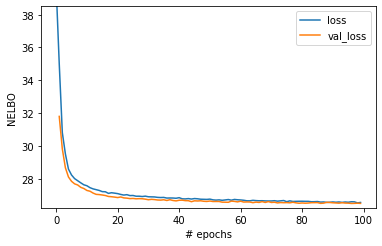

In [46]:
 # curve NELBO
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))
fig, ax = plt.subplots(figsize=golden_size(6))
hist_vae = {k:hist.history[k] for k in ('loss', 'val_loss')}
hist_vae_df = pd.DataFrame(hist_vae)
hist_vae_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99 * hist_vae_df[1:].values.min(),
            1.1 * hist_vae_df[1:].values.max())